In [1]:
# default_exp data.load

In [2]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
# export
from fastseq.core import *
from fastseq.data.external import *
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
import orjson

In [4]:
# hide
from nbdev.showdoc import *

# Data Load Dataframe


> Using the fastai2 `Datasets` to make an time series dataset.

A multivaraite time-series dataloader. 


## Transform catagorical data

In [5]:
# export
class TensorCatI(TensorBase):
    def __new__(cls, x, **kwargs):
        res = tensor(x)
        res.__class__ = TensorCatI
        res._meta = kwargs
        return res
    
class CatSeqI(TensorSeq):
    def __new__(cls, x, **kwargs):
        res = tensor(x)
        res.__class__ = CatSeqI
        res._meta = kwargs
        return res


In [6]:
# export
def _get_classes(df, cat_cols, classes=None):    
    classes = ifnone(classes, {})
    if classes == {}:
        for col in cat_cols:
            classes[col] = unpack_list(list(df[col]))
    return classes

def _make_vocab_df(df,cat_cols, classes = None):
    vocab,o2i = {},{}
    classes = _get_classes(df, cat_cols, classes)
    for col, vals in classes.items():
        vocab[col], o2i[col] = uniqueify(vals, sort=True, bidir=True)
    return vocab, o2i

In [7]:
# export
from IPython.core.debugger import set_trace

class CatTfm(Transform):
    def __init__(self, df:pd.DataFrame = None, cat_cols:[] = None,
                 classes = None, vocab=None, o2i=None):
        if vocab is not None and o2i is not None:
            self.vocab,self.o2i = vocab, o2i
        else:
            self.vocab,self.o2i = _make_vocab_df(df,cat_cols)        
            
    def encodes(self, x: TensorCat):
        r = []
        for i, (o, key) in enumerate(zip(x.o, x._meta['label'])):
            r.append(self.o2i[key][o])#TensorCat
        return TensorCatI(r, label = x._meta['label'])

    def decodes(self, x:TensorCatI):
        if len(x.shape) == 1:
            x = TensorCatI(x[None,:],**x._meta)
        return TensorCat(reverse_lst(self._decode(TensorCatI(x.T,**x._meta))),
                         label = x._meta.get('label', None))    
    
    def encodes(self, x:CatSeq):
        r = []
        for i,(o, key) in enumerate(zip(x.o,x._meta['label'])):
            r.append([])
            for a in o:
                r[i].append(self.o2i[key][a]) #CatSeq
        return CatSeqI(r, label = x._meta['label'])
    
    def decodes(self, x:CatSeqI): 
        if len(x.shape) == 2:
            x = CatSeqI(x[None,:],**x._meta)
        r = []
        for o in x:
            r.append(self._decode(CatSeqI(o,**x._meta)))
        return CatSeq(r, label = x._meta.get('label', None))
    
    def _decode(self, x):   
        r = []        
        for i, (o, key) in enumerate(zip(x, x._meta['label'])):
            r.append([])
            for a in o:
                r[i].append(self.vocab[key][a])
        return r

In [8]:
vocab = {'cat_0':['a','b'],'cat_1':['adam','rdam'],
         'cat_ts_0':['a','b'],'cat_ts_1': ['david','john']}
tfm = CatTfm(vocab = vocab,
             o2i = {'cat_0': {'a': 0, 'b': 1},
                     'cat_1': {'adam': 0, 'rdam': 1},
                     'cat_ts_0': {'a': 0, 'b': 1},
                     'cat_ts_1': {'david': 0, 'john': 1}})
test_eq(tfm.vocab, vocab)

In [11]:
# hide
# check decode w batch
n = np.random.choice(2,(64,2))
o_d = tfm.decode(TensorCatI(n, label=['cat_0','cat_1']))
test_eq(o_d.shape,(64,2))
for i, label in zip(range(2),['cat_0','cat_1']):
    pred, target =o_d.o[0][i], vocab[label][n[0,i]] 
    print('cat',pred,target, n[0,i], vocab[label])
    test_eq(pred,target)

n = np.random.choice(2,(64,2,84))
o = CatSeqI(n.astype(int), label=['cat_ts_0','cat_ts_1'])
o_d = tfm.decode(o)
test_eq(o_d.shape,(64,2,84))
for i, label in zip(range(2),['cat_ts_0','cat_ts_1']):
    print('seq', o_d.o[0][i][0], vocab[label][n[0,i,0]], n[0,i,0])
    test_eq(o_d.o[0][i][0],vocab[label][n[0,i,0]])


cat a a 0 ['a', 'b']
cat adam adam 0 ['adam', 'rdam']
seq b b 1
seq john john 1


In [12]:
o = TensorCat(['a','adam'], label=['cat_0','cat_1'])
test_eq(tfm.encodes(o),tensor([0,0]))
o = CatSeq([['a'],['david']], label=['cat_ts_0','cat_ts_1'])
test_eq(tfm.encodes(o),tensor([[0],[0]]))

In [13]:
test_eq(tfm.decode(TensorCatI([0,0], label=['cat_0','cat_1'])), 
        TensorCat(['a','adam'], label=['cat_0','cat_1']) )

test_eq(tfm.decode(CatSeqI([[0],[0]], label=['cat_ts_0','cat_ts_1'])),
       CatSeq([[['a'],['david']]], label=['cat_ts_0','cat_ts_1']))
tfm.decode(CatSeqI([[0],[0]], label=['cat_ts_0','cat_ts_1']))

CatSeq([[['a'], ['david']]], label = ['cat_ts_0', 'cat_ts_1'])

In [14]:
o = CatSeq([['y','z','z','z'],['adam','rdam','adam','rdam']], label = ['cat_ts_1', 'cat_ts_0'])
df = pd.DataFrame({'cat_ts_1':[[i] for i in 'xzy'],'cat_ts_0':[[i] for i in ['adam','rdam','adam']],
                   'cat':['john','john','david'], 'cat1':['_john','_john','_david']})
tmf = CatTfm(df, ['cat_ts_0','cat_ts_1','cat','cat1'])
tmf(o)
o = TensorCat(['david','_john'], label = ['cat','cat1'])
tmf(o)

TensorCatI([0, 1])

In [15]:
df = pd.DataFrame({'a':[[i,'a'] for i in 'aabb']})
tmf = CatTfm(df, ['a'], {})
print(tmf.vocab)

{'a': (#2) ['a','b']}


In [16]:
o = CatSeq([['a','b','a','a']], label='a')
o_tmf = tmf(o)
test_eq(o_tmf, TensorCatI([[0, 1, 0, 0]]))
test_eq(o_tmf._meta['label'], 'a')
dec_o = tmf.decode(o_tmf)
test_eq(dec_o.o[0],o.o)
dec_o

CatSeq([[['a', 'b', 'a', 'a']]], label = ['a'])

In [17]:
df = pd.DataFrame({'a':[i for i in 'aabb']})
tmf = CatTfm(df, ['a'])
o_tmf = tmf(TensorCat(['a'], label='a'))
test_eq_type(o_tmf,TensorCatI([0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a'],label = 'a'))

o_tmf = tmf(TensorCat(['b'], label='a'))
test_eq_type(o_tmf,TensorCatI([1]))
test_eq(tmf.decode(o_tmf),TensorCat(['b'],label='a'))

In [18]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o_tmf = tmf(TensorCat(['a','b'], label = ['a','a_2']))
test_eq_type(o_tmf,TensorCatI([0,0]))
test_eq(tmf.decode(o_tmf),TensorCat(['a','b'],label = 'a'))

In [19]:
df = pd.DataFrame({'a':[i for i in 'aabb'], 'a_2':[i for i in 'bccb'],})
tmf = CatTfm(df, ['a','a_2'])
o = CatSeq([['a','b','a','a'],['b','b','c','c']], label=['a','a_2'])
o_tmf = tmf(o)
test_eq(o_tmf, CatSeqI([[0, 1, 0, 0],
                        [0, 0, 1, 1]]))
test_eq(o_tmf._meta['label'], ['a','a_2'])
dec_o = tmf.decode(o_tmf)
test_eq(dec_o.o[0],o)
dec_o

CatSeq([[['a', 'b', 'a', 'a'], ['b', 'b', 'c', 'c']]], label = ['a', 'a_2'])

# Dataloader

In [20]:
# export
class TSMulti_(Tuple):
    def _dict(self):
        return {str(str(i)+'_'+str(type(a))):a.shape for i,a in enumerate(self)}


In [21]:
TSMulti_([torch.randn(10,10),torch.randn(10,10),])._dict()

{"0_<class 'torch.Tensor'>": torch.Size([10, 10]),
 "1_<class 'torch.Tensor'>": torch.Size([10, 10])}

## make_ids

In [22]:
# export
def get_classes(path:Path):
    return get_meta(path)['classes']
                    
def make_vocab(path, classes = None):
    if classes is None:
        classes = get_classes(path)
    vocab, o2i = {},{}
    for col, vals in classes.items():
        vocab[col], o2i[col] = uniqueify(vals, sort=True, bidir=True)
    return vocab, o2i

In [23]:
df = get_df([600, 888, 1200])
path = Path('../data/test_data')
save_df(df, path)
get_classes(path)

{'cat_0': ['b', 'a'],
 'cat_1': ['rdam', 'adam'],
 'cat_ts_0': ['b', 'a'],
 'cat_ts_1': ['david', 'john']}

In [24]:
make_vocab(path)[0]

{'cat_0': (#2) ['a','b'],
 'cat_1': (#2) ['adam','rdam'],
 'cat_ts_0': (#2) ['a','b'],
 'cat_ts_1': (#2) ['david','john']}

In [25]:
# export
def make_ids(dl):  
    """Make ids if the sequence is shorter than `min_seq_len`, it will drop that sequence."""
    # Slice each time series into examples, assigning IDs to each
    last_id = 0
    n_dropped = 0
    n_needs_padding = 0
    dl._ids = {}
    for f in dl.dataset:
        dp = get_ts_datapoint(f)  
        num_examples = (dp['_length'] - dl.lookback - dl.horizon + dl.step) // dl.step
        # Time series shorter than the forecast horizon need to be dropped.
        if dp['_length'] < dl.min_seq_len:
            n_dropped += 1
            continue
        # For short time series zero pad the input
        if dp['_length'] < dl.lookback + dl.horizon:
            n_needs_padding += 1
            num_examples = 1
        for j in range(num_examples):
            dl._ids[last_id + j] = (str(f), j * dl.step)
        last_id += num_examples

    # Inform user about time series that were too short
    if n_dropped > 0:
        print("Dropped {}/{} time series due to length.".format(
                n_dropped, len(dl.dataset)))

    # Inform user about time series that were short
    if n_needs_padding > 0:
        print("Need to pad {}/{} time series due to length.".format(
                n_needs_padding, len(dl.dataset)))
    # Store the number of training examples
    dl.n = int(dl._ids.__len__() )
    return dl, dl.n
    

In [26]:
# needs a test

## get_part_of_ts

In [27]:
# export
@typedispatch
def get_part_of_ts(x, lookback_id, length, pad=np.mean, t = tensor, **kwargs):
    if x.shape[-1] < length:
        # If the time series is too short, we pad
        padding = pad(x, -1)
        x = t(np.pad(
            x, # report issue https://github.com/numpy/numpy/issues/15606
            pad_width=((0, 0), (length - x.shape[-1], 0)),
            mode='constant',
            constant_values=padding
        ), **kwargs).float()
        assert x.shape == (x.shape[0],length), f"{x.shape}\t,{lookback_id}, 'tsshape':{x.shape}"
    else:
        x = t(x[:,lookback_id:lookback_id + length], **kwargs).float()
    return x


In [28]:
x = np.vstack([np.arange(10.)]*2)
test_eq(get_part_of_ts(x, 2, 5), torch.cat([torch.arange(2,7.)[None,:]]*2))
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                                          [4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

# report issue https://github.com/numpy/numpy/issues/15606
x = np.arange(10.)[None,:]
test_eq(get_part_of_ts(x, 0, 11), tensor([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]))

In [29]:
# hide
x = np.arange(10.)[None,:]
o =get_part_of_ts(x, 0, 11, t = TensorBase, label='a')
test_eq_type(o, TensorBase([[4.5, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])) 
test_eq(o._meta, {'label':'a'})

In [30]:
# export
@typedispatch
def get_part_of_ts(x:list, lookback_id, length, t = L, **kwargs):
    if len(x[0]) < length:
        # If the time series is too short, we pad
        padding = [o[-1] for o in x]
        pad_len = length - len(x[0])
        x = [o[lookback_id:lookback_id + length] + [padding[i]]*pad_len for i,o in enumerate(x)]
    else:
        x = [o[lookback_id:lookback_id + length] for o in x]
    return t(x, **kwargs)

@typedispatch
def get_part_of_ts(x:L, *args, **kwargs):
    return get_part_of_ts(list(x),*args, **kwargs)

In [31]:
x = L(['a','b']*5,['z','x']*5)
o =get_part_of_ts(x, 1, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [32]:
x = L(['a','b']*2, ['z','x']*2)
o =get_part_of_ts(x, 0, 5)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),L)

In [33]:
# hide
x = [[1,2]*2, [10,11]*2]
o =get_part_of_ts(x, 0, 5, t = TensorSeq)
test_eq(len(o), 2)
for a in o:
    test_eq(len(a),5)
test_eq(type(o),TensorSeq)

## get_id

In [34]:
# export
catagories = dict( )
catagories[type('1')] = dict(seq = CatSeq,  cat = TensorCat,  multi = TSMulti)
catagories[type(1)]   = dict(seq = CatSeqI, cat = TensorCatI, multi =  TSMulti_)

def split_ts_con(ts, y_name, meta:Meta):  
    ts_con_names = [o for o in meta['col_names']['ts_con_names'] if o != y_name]
    y = ts['ts_con'][y_name]
    tsx = [ts['ts_con'][k] for k in ts_con_names]
    return y, tsx, ts_con_names
    

def json2TSMulti(ts, lookback_id, y_name, lookback, horizon, meta:Meta):
    y, tsx, ts_con_names = split_ts_con(ts, y_name, meta)
    
    y = get_part_of_ts([y], lookback_id, lookback + horizon,
                       t = TensorSeq, label=[y_name + '_y'], m=['g'])
    x = TensorSeq(y[:,:lookback], label=[y_name + '_x'], m=['g'])
    tsx_con = get_part_of_ts(tsx, lookback_id, lookback + horizon,
                             t = TensorSeq, label=ts_con_names)
    con = TensorCon(ts.get_ts(meta,'con'), label=meta['col_names']['con_names'])
    tsx_cat = ts.get_ts(meta,'ts_cat')
    types = catagories[type(tsx_cat[0][0])]
    
    tsx_cat = get_part_of_ts(tsx_cat, lookback_id, lookback + horizon,
                             t = types['seq'], label=meta['col_names']['ts_cat_names'])        
    r = [x, tsx_con, tsx_cat]
    r.append(types['cat'](ts.get_ts(meta,'cat'), label=meta['col_names']['cat_names']))
    r.append(con)      
    r.append(y)
    return types['multi'](r)

In [37]:
p = Path('../data/test_data')
f = del_create([2000, 2000, 2000], path = p, use_str=True)
ts = get_ts_datapoint(f[0])
r = json2TSMulti(ts, 1000, 'x',100, 10, get_meta(path))
test_eq(len(r), 6)
for a, t, shape in zip(r, [TensorSeq, TensorSeq, CatSeq, TensorCat, TensorCon, TensorSeq], [(1,100),(2,110),(2,110),[2],[2],[1,110]]):
    test_eq(type(a), t)
    test_eq(list(a.shape), shape)
print({str(type(a))+str(i):a.shape for i,a in enumerate(r)})


{"<class 'fastseq.core.TensorSeq'>0": torch.Size([1, 100]), "<class 'fastseq.core.TensorSeq'>1": torch.Size([2, 110]), "<class 'fastseq.core.CatSeq'>2": (2, 110), "<class 'fastseq.core.TensorCat'>3": (2,), "<class 'fastseq.core.TensorCon'>4": torch.Size([2]), "<class 'fastseq.core.TensorSeq'>5": torch.Size([1, 110])}


In [38]:
p = Path('../data/test_data')
f = del_create([2000, 2000, 2000],path = p, use_str=False)
ts = get_ts_datapoint(f[0])
r = json2TSMulti(ts, 1000, 'x',100, 10, get_meta(path))
test_eq(len(r), 6)
for a, t, shape in zip(r, [TensorSeq, TensorSeq, CatSeqI, TensorCatI, TensorCon, TensorSeq], [(1,100),(2,110),(2,110),[2],[2],[1,110]]):
    test_eq(type(a), t)
    test_eq(list(a.shape), shape)
print({str(type(a))+str(i):a.shape for i,a in enumerate(r)})

{"<class 'fastseq.core.TensorSeq'>0": torch.Size([1, 100]), "<class 'fastseq.core.TensorSeq'>1": torch.Size([2, 110]), "<class '__main__.CatSeqI'>2": torch.Size([2, 110]), "<class '__main__.TensorCatI'>3": torch.Size([2]), "<class 'fastseq.core.TensorCon'>4": torch.Size([2]), "<class 'fastseq.core.TensorSeq'>5": torch.Size([1, 110])}


## Multi Tfm

In [39]:
# export
class CatMultiTfm(ItemTransform):
    @delegates(CatTfm.__init__)
    def __init__(self, **kwargs): # maybe change to proccs
        self.f = CatTfm(**kwargs)
        
    def encodes(self, o):
        if type(o[2]) == CatSeq:
            return TSMulti_(self.f(a) for a in o)
        return o
    
    def decodes(self, o): 
        return TSMulti(self.f.decode(a) for a in o)
    

In [40]:
# normal usages with just CatSeq/TensorCat -> CatSeqI/TensorCatI -> CatSeq/TensorCat, so:
# str -> int -> str
path = Path('../data/test_data')
del_create([14,14,16],path = path)
o = json2TSMulti(get_ts_datapoint(get_files(path,extensions='.json')[0]), 0, 'x', 10, 3, get_meta(path))

vocab,o2i = make_vocab(get_files(path,extensions='.json'), get_meta(path)['classes'])
t = CatMultiTfm(vocab = vocab, o2i=o2i)

o_tmf = t(o)
test_eq_type(o_tmf[2], CatSeqI([[o2i[k][a] for a in v] for k,v in o[2].dict().items()],
                               label = ['cat_ts_1', 'cat_ts_0']))
test_eq(type(o_tmf[3]), type(TensorCatI([0,0])))

o_b = t.decodes(o_tmf)
for a, a_b in zip(o, o_b):
    if type(a) == CatSeq: # need because batch is expected
        test_eq(a_b.o[0], a.o)
        test_eq(a_b._meta, a._meta)
    else:
        test_eq(a_b, a)
    
test_eq(type(o_b), type(TSMulti(1)))

In [41]:
# faster usages with CatSeq/TensorCat only existing after the decode:
# int -> int -> str
path = Path('../data/test_data')
del_create([14,14,16], path = path, use_str = False)
o = json2TSMulti(get_ts_datapoint(get_files(path,extensions='.json')[0]), 0, 'x', 10, 3, get_meta(path))
print('The second datapoint:\t',o[2],'\n')
vocab,o2i = make_vocab(get_files(path,extensions='.json'), get_meta(path)['classes'])
t = CatMultiTfm(vocab = vocab, o2i=o2i)

o_tmf = t(o)
test_eq_type(o_tmf[2], o[2])
test_eq_type(o_tmf[3], o[3])
print('The first transform:\t',o_tmf[2],'\n')
o_b = t.decodes(o_tmf)
print('After decode:\t\t',o_b[2])
for a, t in zip(o_b, [TensorSeq, TensorSeq, CatSeq, TensorCat, TensorCon, TensorSeq]):
    test_eq(type(a), t)
    
test_eq(type(o_b), type(TSMulti(1)))

The second datapoint:	 CatSeqI([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]]) 

The first transform:	 CatSeqI([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]]) 

After decode:		 CatSeq([[['a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a', 'b', 'a'], ['david', 'john', 'david', 'john', 'david', 'john', 'david', 'john', 'david', 'john', 'david', 'john', 'david']]], label = ['cat_ts_0', 'cat_ts_1'])


In [42]:
# hide
# test the other route is still working
df = get_df([14,14])
Mtmf = CatMultiTfm(df=df, cat_cols=['cat_ts_1', 'cat_ts_0', 'cat_0','cat_1'])
o = TSMulti(TensorBase([1]), TensorCat(['adam','b'], label=['cat_1','cat_0']), 
            CatSeq([['david','david'],['a','b']], label=['cat_ts_1','cat_ts_0']))
o_tmf = Mtmf.encodes(o)
test_eq(o_tmf,TSMulti_(TensorBase([1]), TensorCatI([0,1]), CatSeqI([[0,0],[0,1]])))
o_b = Mtmf.decodes(o_tmf)

for a, a_b in zip(o, o_b):
    if type(a) == CatSeq: # need because batch is expected
        test_eq(a_b.o[0], a.o)
        test_eq(a_b._meta, a._meta)
    else:
        test_eq(a_b, a)
        
test_eq(type(o_b), type(TSMulti(1)))


## Dataloader

In [43]:
# export
class MTSDataLoader(TfmdDL):    
    @delegates(TfmdDL.__init__)
    def __init__(self, dataset, meta:Meta, y_name = 'x', lookback=14, horizon=7, step=1, min_seq_len=None,
                train = True, procs = None, vocab=None, o2i=None, **kwargs):
        assert type(meta) == Meta or type(meta) == dict
        store_attr(self,'dataset,y_name,lookback,horizon,step,meta')
        self.min_seq_len = ifnone(min_seq_len, lookback) 
        self, n = make_ids(self)
        if vocab is None: # from MTSDataLoaders
            vocab, o2i = make_vocab(dataset, classes = self.meta['classes'])
        kwargs['after_item'] = kwargs.get('after_item', CatMultiTfm(vocab = vocab, o2i=o2i))        
        super().__init__(dataset=self.dataset, **kwargs)
        self.n = n
        self.procs = Pipeline(L(procs))
        self.procs.setup(self, train)
        
    @delegates(__init__)
    @classmethod
    def from_path(cls, path, **kwargs):
        return cls(get_files(path, extensions='.json'), get_meta(path),**kwargs)
    
    @delegates(TfmdDL.new)
    def new(self, dataset=None, cls=None, **kwargs):
        for k,v in {k:getattr(self,k) for k in ['meta','horizon', 'lookback', 'step']}.items():
            if k not in kwargs:
                kwargs[k] = v
        res = super().new(dataset = dataset,cls= cls, y_name= self.y_name, **kwargs)
        res, n = make_ids(res)
        res.n = n        
        return res    
    
    def create_item(self, idx):
        if idx>=self.n:
            raise IndexError
        fpath, lookback_id = self._ids[idx]
        ts = get_ts_datapoint(fpath)
        return json2TSMulti(ts, lookback_id, self.y_name, self.lookback, self.horizon, self.meta)         
    

In [44]:
path = Path('../data/test_data')
del_create([2000, 2000, 2000], path = path, use_str = True)
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 28, horizon = 28*3, num_workers = 0)

for o in dl:
    assert o[0].shape[1:] == (1,28), o[0].shape
    assert o[0].shape[1:] == (1,28), o[0].shape

In [45]:
def get_all(dl):
    for o in dl:
        assert len(o)

In [46]:
%load_ext line_profiler

In [238]:
%lprun -f json2TSMulti get_all(dl)

Timer unit: 1e-06 s

Total time: 5.28402 s
File: <ipython-input-65-2c9cf85e528f>
Function: json2TSMulti at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def json2TSMulti(ts, lookback_id, y_name, lookback, horizon, meta:Meta):
    14      5667      58886.0     10.4      1.1      y, tsx, ts_con_names = split_ts_con(ts, y_name, meta)
    15                                               
    16      5667       8681.0      1.5      0.2      y = get_part_of_ts([y], lookback_id, lookback + horizon,
    17      5667    1323257.0    233.5     25.0                         t = TensorSeq, label=[y_name + '_y'], m=['g'])
    18      5667     700918.0    123.7     13.3      x = TensorSeq(y[:,:lookback], label=[y_name + '_x'], m=['g'])
    19      5667       8491.0      1.5      0.2      tsx_con = get_part_of_ts(tsx, lookback_id, lookback + horizon,
    20      5667    1240961.0    219.0     23.5                               

In [50]:
# hide
path = Path('../data/test_data')
del_create([200, 200, 200], path = path, use_str = False)
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2, num_workers = 1)

for o in dl:
    assert o[0].shape[1:] == (1,10), o[0].shape
    assert o[0].shape[1:] == (1,10), o[0].shape

In [51]:
%%time
# hide
for o in dl:
    pass

CPU times: user 27.1 ms, sys: 19.4 ms, total: 46.5 ms
Wall time: 386 ms


# Showing

In [58]:
# export

def _show_batch_class(self, b=None, max_n=9, ctxs=None, show=True, **kwargs):
    if b is None: b = self.one_batch()
    x, y, its = self._pre_show_batch(b, max_n=max_n)
    x = self.after_item.decode(TSMulti_(x))
    if not show: return x, y, its
    show_batch(x,y,its, ctxs=ctxs, max_n=max_n, **kwargs)

MTSDataLoader.show_batch = _show_batch_class

In [59]:
# export
from fastai2.vision.data import get_grid
@typedispatch
def show_batch(x:TSMulti, y:TensorSeq, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

@typedispatch
def show_batch(x:TSMulti, y:None, its, *args, ctxs=None, max_n=10, rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        o = TSMulti([type(o)(o[i],**o[i]._meta) for o in x if o.shape[-1] > 0])
        ctx = o.show(ctx=ctx)
    return ctxs

In [60]:
show_batch

(TSMulti,NoneType) -> show_batch
(TSMulti,TensorSeq) -> show_batch
(TensorImage,TensorImage) -> show_batch
(TensorImage,object) -> show_batch
(Tabular,object) -> show_batch
(object,object) -> show_batch

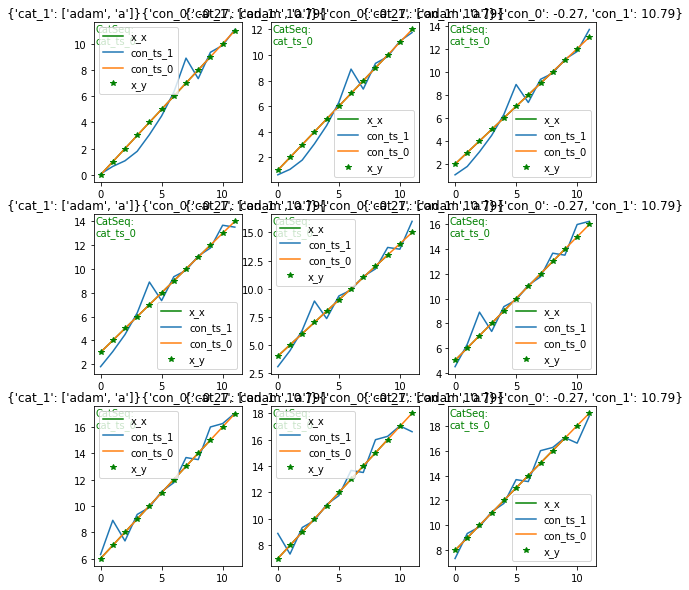

In [61]:
horizon,lookback = 2,9
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= 10, horizon = 2,)
dl.show_batch()

In [62]:
#export
# from fastseq.data.load_pd import *

@typedispatch
def show_results(x:TSMulti, y, its, outs, ctxs=None, max_n=9,rows=None, cols=None, figsize=None, **kwargs):
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), add_vert=1, figsize=figsize, **kwargs)
    for i, ctx in enumerate(ctxs):  
        r = [type(o)(o,**o._meta) for o in its[i] if o.shape[-1] > 0] 
        r.append(type(its[i][-1])(outs[i][0], label=['pred_y'], m=['r']))
        o = TSMulti(r)        
        ctx = o.show(ctx=ctx) 


In [63]:
show_results

(TSMulti,object) -> show_results
(object,object) -> show_results

In [64]:
a = TensorSeq([0], label = ['a'])
a._meta

{'label': ['a']}

(#4) [0,45989545115648.0,4.331696567825203e+16,'00:00']


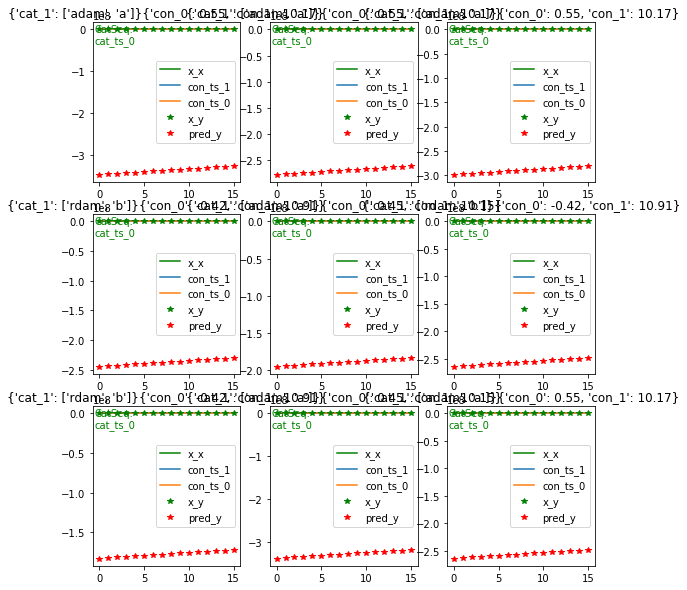

In [65]:
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.ones(in_f,in_f+out_f)), nn.Parameter(torch.zeros(in_f+out_f))
    def forward(self, x,*args): 
        assert x.shape[1:] == (1,10), x
        return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)

horizon,lookback = 6, 10
df = get_df([160, 160, 160])
save_df(df, path)
path = Path('../data/test_data')
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)

learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))
learn.fit(1)
learn.show_results(max_n=9)

(#4) [0,2.7548473428331725e+17,9.261688521746956e+20,'00:00']


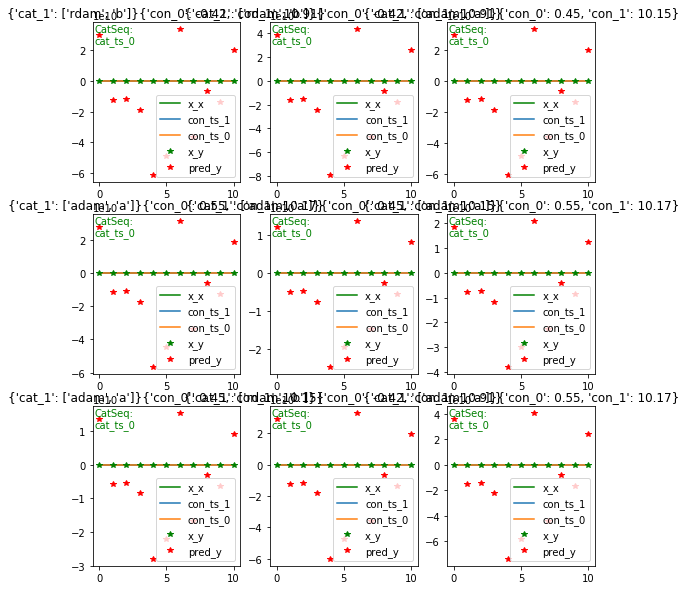

In [66]:
# hide
# wo tsx
class RegModel(Module):
    def __init__(self, in_f, out_f): 
        self.a,self.b = nn.Parameter(torch.randn(in_f,in_f+out_f)),nn.Parameter(torch.randn(in_f+out_f))
    def forward(self, x, *args): return (torch.mm(x[:,0,:],self.a) + self.b)[:,None,:]
    
def synth_learner(lookback, horizon, cuda=False, lr=1e-3, data=None, **kwargs):
    return Learner(data, RegModel(lookback,horizon), lr=lr, loss_func=MSELossFlat(),
                   opt_func=partial(SGD, mom=0.9), **kwargs)
horizon,lookback = 2,9
df = get_df()
dl = MTSDataLoader.from_path(path, y_name = 'x', lookback= lookback, horizon = horizon)
learn = synth_learner(lookback, horizon, data=DataLoaders(dl, dl))

learn.fit(1)
learn.show_results(max_n=9)

In [67]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.
Converted 05_data.m5.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted tab.model.ipynb.


In [149]:
git_add('02_data.load.ipynb', commit_msg='new location TSMutlti_')

Converted 02_data.load.ipynb.


['/home/tako/dev/fastseq/fastseq/data/load.py',
 '/home/tako/dev/fastseq/nbs/02_data.load.ipynb']